# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:09<00:00, 6.19KFile/s] 


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

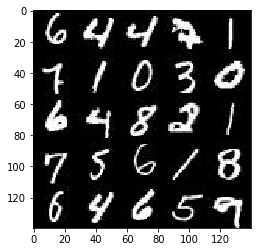

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

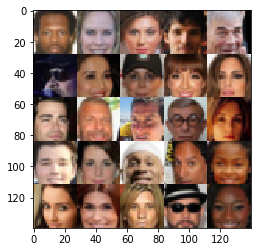

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name='real_inputs')
    z_inputs = tf.placeholder(tf.float32,(None,z_dim),name='z_inputs')
    lr = tf.placeholder(tf.float32,name='learning_rate')
    return real_inputs, z_inputs, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        alpha=0.2
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #4*4*256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [16]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        alpha=0.2
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*128)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 128))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x128 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        x3 = tf.layers.conv2d_transpose(x2, 512, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x512
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [17]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function

    # Build the model
    g_model = generator(input_z, out_channel_dim=out_channel_dim)#?
    # g_model is the generator output

    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                          labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                          labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
                 tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_model_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [18]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [20]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    tf.reset_default_graph() 
    print(data_shape)
    channel=1
    if data_image_mode=='RGB':
        channel=3
    input_real, input_z,lr = model_inputs(data_shape[1],data_shape[2],channel, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channel)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    samples, losses = [], []
    steps = 0
    print_every=10
    show_every=300
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
            
                # Run optimizers
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images*2, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images*2})
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images*2})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    #Print the current image
                    show_generator_output(sess, 25, input_z, channel, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
Epoch 1/2... Discriminator Loss: 0.3468... Generator Loss: 12.1726
Epoch 1/2... Discriminator Loss: 2.6356... Generator Loss: 0.8500
Epoch 1/2... Discriminator Loss: 1.1253... Generator Loss: 3.5944
Epoch 1/2... Discriminator Loss: 2.4045... Generator Loss: 1.0344
Epoch 1/2... Discriminator Loss: 0.5551... Generator Loss: 1.5799
Epoch 1/2... Discriminator Loss: 1.5572... Generator Loss: 2.3681
Epoch 1/2... Discriminator Loss: 1.5214... Generator Loss: 2.8494
Epoch 1/2... Discriminator Loss: 1.5813... Generator Loss: 0.3775
Epoch 1/2... Discriminator Loss: 1.2763... Generator Loss: 0.8555
Epoch 1/2... Discriminator Loss: 1.0584... Generator Loss: 0.8647
Epoch 1/2... Discriminator Loss: 1.1820... Generator Loss: 0.6337
Epoch 1/2... Discriminator Loss: 1.7432... Generator Loss: 0.2985
Epoch 1/2... Discriminator Loss: 1.3916... Generator Loss: 1.3057
Epoch 1/2... Discriminator Loss: 1.5065... Generator Loss: 0.4743
Epoch 1/2... Discriminator Loss: 1.2108... Generator Los

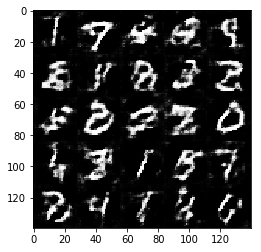

Epoch 1/2... Discriminator Loss: 1.2947... Generator Loss: 1.8620
Epoch 1/2... Discriminator Loss: 2.0426... Generator Loss: 0.1934
Epoch 1/2... Discriminator Loss: 1.4054... Generator Loss: 1.8207
Epoch 1/2... Discriminator Loss: 1.3875... Generator Loss: 0.3692
Epoch 1/2... Discriminator Loss: 1.2213... Generator Loss: 0.5717
Epoch 1/2... Discriminator Loss: 1.0513... Generator Loss: 1.0182
Epoch 1/2... Discriminator Loss: 1.4174... Generator Loss: 0.3935
Epoch 1/2... Discriminator Loss: 1.2457... Generator Loss: 0.5569
Epoch 1/2... Discriminator Loss: 1.2702... Generator Loss: 1.3961
Epoch 1/2... Discriminator Loss: 1.0623... Generator Loss: 0.9211
Epoch 1/2... Discriminator Loss: 1.2217... Generator Loss: 0.6792
Epoch 1/2... Discriminator Loss: 1.0781... Generator Loss: 0.9721
Epoch 1/2... Discriminator Loss: 1.1388... Generator Loss: 1.0170
Epoch 1/2... Discriminator Loss: 1.4953... Generator Loss: 1.6823
Epoch 1/2... Discriminator Loss: 1.0415... Generator Loss: 0.7391
Epoch 1/2.

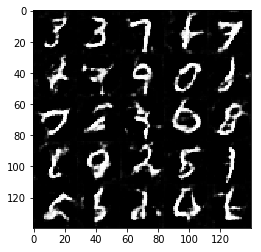

Epoch 1/2... Discriminator Loss: 0.9293... Generator Loss: 1.0499
Epoch 1/2... Discriminator Loss: 1.4609... Generator Loss: 2.8318
Epoch 1/2... Discriminator Loss: 0.7061... Generator Loss: 1.0441
Epoch 1/2... Discriminator Loss: 1.7112... Generator Loss: 0.3136
Epoch 1/2... Discriminator Loss: 1.4599... Generator Loss: 0.3636
Epoch 1/2... Discriminator Loss: 2.0360... Generator Loss: 3.1230
Epoch 1/2... Discriminator Loss: 1.3002... Generator Loss: 0.4368
Epoch 1/2... Discriminator Loss: 0.7268... Generator Loss: 1.1108
Epoch 1/2... Discriminator Loss: 1.2685... Generator Loss: 0.4445
Epoch 1/2... Discriminator Loss: 1.2358... Generator Loss: 0.5136
Epoch 1/2... Discriminator Loss: 1.7245... Generator Loss: 0.4561
Epoch 1/2... Discriminator Loss: 1.0584... Generator Loss: 1.3659
Epoch 1/2... Discriminator Loss: 1.2201... Generator Loss: 0.5188
Epoch 1/2... Discriminator Loss: 1.1433... Generator Loss: 1.3253
Epoch 1/2... Discriminator Loss: 0.8416... Generator Loss: 1.1043
Epoch 1/2.

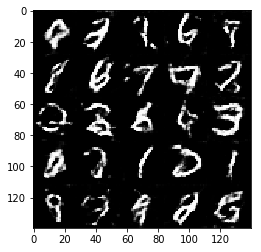

Epoch 1/2... Discriminator Loss: 0.7691... Generator Loss: 1.0361
Epoch 1/2... Discriminator Loss: 0.8546... Generator Loss: 0.7778
Epoch 1/2... Discriminator Loss: 1.0994... Generator Loss: 0.5426
Epoch 2/2... Discriminator Loss: 0.7406... Generator Loss: 0.9820
Epoch 2/2... Discriminator Loss: 0.8908... Generator Loss: 0.8138
Epoch 2/2... Discriminator Loss: 0.6317... Generator Loss: 1.4134
Epoch 2/2... Discriminator Loss: 1.4656... Generator Loss: 3.0075
Epoch 2/2... Discriminator Loss: 0.9832... Generator Loss: 0.6521
Epoch 2/2... Discriminator Loss: 0.7454... Generator Loss: 0.9837
Epoch 2/2... Discriminator Loss: 0.9048... Generator Loss: 1.3318
Epoch 2/2... Discriminator Loss: 0.8017... Generator Loss: 0.9061
Epoch 2/2... Discriminator Loss: 0.8580... Generator Loss: 0.8411
Epoch 2/2... Discriminator Loss: 0.6534... Generator Loss: 1.3463
Epoch 2/2... Discriminator Loss: 0.9692... Generator Loss: 1.5948
Epoch 2/2... Discriminator Loss: 0.8760... Generator Loss: 1.1297
Epoch 2/2.

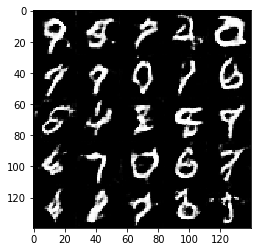

Epoch 2/2... Discriminator Loss: 0.6716... Generator Loss: 0.9921
Epoch 2/2... Discriminator Loss: 0.5195... Generator Loss: 1.3301
Epoch 2/2... Discriminator Loss: 1.0271... Generator Loss: 0.6206
Epoch 2/2... Discriminator Loss: 0.5779... Generator Loss: 1.1251
Epoch 2/2... Discriminator Loss: 0.4027... Generator Loss: 1.4519
Epoch 2/2... Discriminator Loss: 0.4019... Generator Loss: 1.5142
Epoch 2/2... Discriminator Loss: 0.7121... Generator Loss: 1.0225
Epoch 2/2... Discriminator Loss: 0.6004... Generator Loss: 1.1617
Epoch 2/2... Discriminator Loss: 0.6689... Generator Loss: 1.9903
Epoch 2/2... Discriminator Loss: 1.1568... Generator Loss: 0.6414
Epoch 2/2... Discriminator Loss: 0.7636... Generator Loss: 0.8534
Epoch 2/2... Discriminator Loss: 0.9439... Generator Loss: 0.7079
Epoch 2/2... Discriminator Loss: 1.3479... Generator Loss: 0.4058
Epoch 2/2... Discriminator Loss: 0.5702... Generator Loss: 1.1151
Epoch 2/2... Discriminator Loss: 1.8699... Generator Loss: 0.3082
Epoch 2/2.

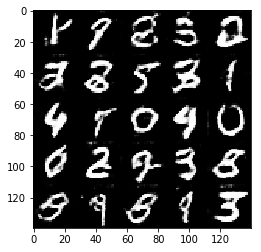

Epoch 2/2... Discriminator Loss: 0.8913... Generator Loss: 0.8404
Epoch 2/2... Discriminator Loss: 1.0443... Generator Loss: 0.6592
Epoch 2/2... Discriminator Loss: 3.0139... Generator Loss: 0.1237
Epoch 2/2... Discriminator Loss: 0.6923... Generator Loss: 1.0755
Epoch 2/2... Discriminator Loss: 1.0777... Generator Loss: 0.5893
Epoch 2/2... Discriminator Loss: 1.0345... Generator Loss: 0.6228
Epoch 2/2... Discriminator Loss: 0.6364... Generator Loss: 1.0068
Epoch 2/2... Discriminator Loss: 0.7814... Generator Loss: 0.9464
Epoch 2/2... Discriminator Loss: 0.7392... Generator Loss: 0.9873
Epoch 2/2... Discriminator Loss: 0.5435... Generator Loss: 1.1171
Epoch 2/2... Discriminator Loss: 0.6625... Generator Loss: 1.0607
Epoch 2/2... Discriminator Loss: 1.3404... Generator Loss: 0.6169
Epoch 2/2... Discriminator Loss: 0.8225... Generator Loss: 0.9465
Epoch 2/2... Discriminator Loss: 0.4533... Generator Loss: 1.4771
Epoch 2/2... Discriminator Loss: 0.3667... Generator Loss: 2.1966
Epoch 2/2.

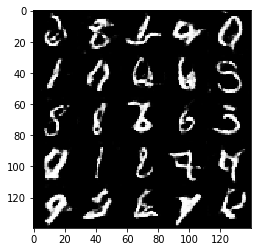

Epoch 2/2... Discriminator Loss: 1.9270... Generator Loss: 4.0343
Epoch 2/2... Discriminator Loss: 0.4506... Generator Loss: 1.4646
Epoch 2/2... Discriminator Loss: 1.0194... Generator Loss: 0.6470
Epoch 2/2... Discriminator Loss: 1.5573... Generator Loss: 0.4180
Epoch 2/2... Discriminator Loss: 0.6650... Generator Loss: 1.1086
Epoch 2/2... Discriminator Loss: 0.5767... Generator Loss: 1.3002
Epoch 2/2... Discriminator Loss: 0.5599... Generator Loss: 1.3817


IndexError: list index out of range

In [21]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3)
Epoch 1/1... Discriminator Loss: 0.1463... Generator Loss: 18.7167
Epoch 1/1... Discriminator Loss: 0.2305... Generator Loss: 18.2507
Epoch 1/1... Discriminator Loss: 2.7795... Generator Loss: 0.8944
Epoch 1/1... Discriminator Loss: 0.9912... Generator Loss: 1.0900
Epoch 1/1... Discriminator Loss: 3.0805... Generator Loss: 0.0787
Epoch 1/1... Discriminator Loss: 0.4071... Generator Loss: 2.7034
Epoch 1/1... Discriminator Loss: 1.9064... Generator Loss: 0.3025
Epoch 1/1... Discriminator Loss: 0.8001... Generator Loss: 1.1564
Epoch 1/1... Discriminator Loss: 0.5100... Generator Loss: 2.3349
Epoch 1/1... Discriminator Loss: 0.6953... Generator Loss: 1.1643
Epoch 1/1... Discriminator Loss: 0.7244... Generator Loss: 1.1008
Epoch 1/1... Discriminator Loss: 0.5641... Generator Loss: 1.2996
Epoch 1/1... Discriminator Loss: 0.7059... Generator Loss: 1.6240
Epoch 1/1... Discriminator Loss: 0.4411... Generator Loss: 2.5026
Epoch 1/1... Discriminator Loss: 0.7213... Generator L

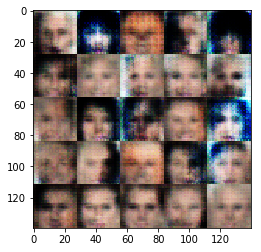

Epoch 1/1... Discriminator Loss: 0.6963... Generator Loss: 1.6401
Epoch 1/1... Discriminator Loss: 1.9456... Generator Loss: 0.1777
Epoch 1/1... Discriminator Loss: 1.0145... Generator Loss: 1.0798
Epoch 1/1... Discriminator Loss: 0.6293... Generator Loss: 1.6097
Epoch 1/1... Discriminator Loss: 1.2316... Generator Loss: 0.4979
Epoch 1/1... Discriminator Loss: 0.9310... Generator Loss: 1.0783
Epoch 1/1... Discriminator Loss: 2.9911... Generator Loss: 4.7360
Epoch 1/1... Discriminator Loss: 0.9189... Generator Loss: 4.7994
Epoch 1/1... Discriminator Loss: 1.9208... Generator Loss: 0.2034
Epoch 1/1... Discriminator Loss: 0.7571... Generator Loss: 1.1619
Epoch 1/1... Discriminator Loss: 0.5886... Generator Loss: 1.6140
Epoch 1/1... Discriminator Loss: 1.0334... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 1.7025
Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 0.3676
Epoch 1/1... Discriminator Loss: 1.4958... Generator Loss: 1.8428
Epoch 1/1.

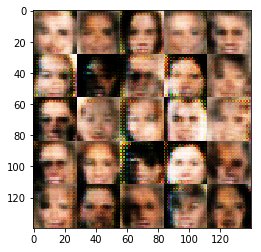

Epoch 1/1... Discriminator Loss: 1.0494... Generator Loss: 0.9577
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.4789
Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.6913
Epoch 1/1... Discriminator Loss: 1.5666... Generator Loss: 0.7233
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.8218
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.6755
Epoch 1/1... Discriminator Loss: 1.2620... Generator Loss: 0.7513
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.9006
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.6367
Epoch 1/1... Discriminator Loss: 1.3075... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 0.5562
Epoch 1/1.

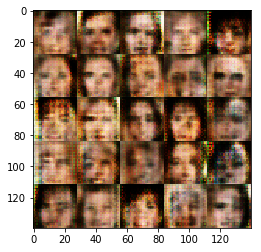

Epoch 1/1... Discriminator Loss: 1.1096... Generator Loss: 0.6379
Epoch 1/1... Discriminator Loss: 0.4369... Generator Loss: 1.4192
Epoch 1/1... Discriminator Loss: 1.1496... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.2066... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 2.5407... Generator Loss: 2.4693
Epoch 1/1... Discriminator Loss: 0.9973... Generator Loss: 1.1062
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.4797
Epoch 1/1... Discriminator Loss: 1.6582... Generator Loss: 2.1958
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.1998... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 0.6830
Epoch 1/1... Discriminator Loss: 1.2748... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.7510
Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.8015
Epoch 1/1.

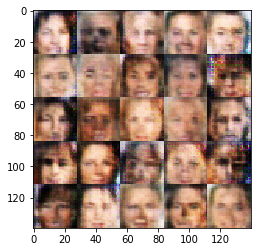

Epoch 1/1... Discriminator Loss: 1.1952... Generator Loss: 0.9136
Epoch 1/1... Discriminator Loss: 1.5537... Generator Loss: 0.5697
Epoch 1/1... Discriminator Loss: 1.2728... Generator Loss: 0.7790
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 1.0516
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 0.8630
Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.8862
Epoch 1/1... Discriminator Loss: 1.3011... Generator Loss: 0.6987
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.2283... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7268
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.5393
Epoch 1/1... Discriminator Loss: 1.2173... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.7641
Epoch 1/1... Discriminator Loss: 1.2466... Generator Loss: 0.7254
Epoch 1/1.

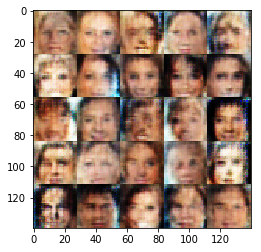

Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 0.8836
Epoch 1/1... Discriminator Loss: 1.1650... Generator Loss: 0.8511
Epoch 1/1... Discriminator Loss: 1.4955... Generator Loss: 0.9941
Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.8355
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.2944... Generator Loss: 0.7055
Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 0.5419
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 1.6124... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 1.5256... Generator Loss: 0.4359
Epoch 1/1... Discriminator Loss: 1.2373... Generator Loss: 0.8601
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.7639
Epoch 1/1... Discriminator Loss: 1.4930... Generator Loss: 0.6650
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.5972
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.7439
Epoch 1/1.

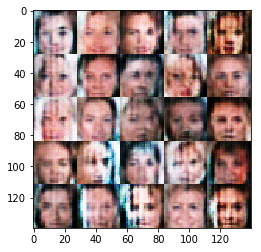

Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.5419
Epoch 1/1... Discriminator Loss: 0.7773... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 0.4034
Epoch 1/1... Discriminator Loss: 0.8296... Generator Loss: 1.2262
Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 0.6385
Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 1.0016
Epoch 1/1... Discriminator Loss: 1.1544... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.4936... Generator Loss: 0.5730
Epoch 1/1... Discriminator Loss: 1.0346... Generator Loss: 0.8327
Epoch 1/1... Discriminator Loss: 0.9573... Generator Loss: 0.8681
Epoch 1/1... Discriminator Loss: 1.2033... Generator Loss: 0.8282
Epoch 1/1... Discriminator Loss: 1.2970... Generator Loss: 0.7286
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.6013
Epoch 1/1... Discriminator Loss: 0.9399... Generator Loss: 1.4709
Epoch 1/1.

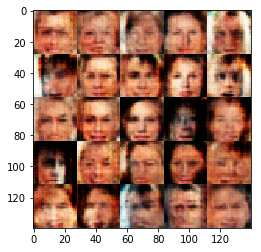

Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 1.1550
Epoch 1/1... Discriminator Loss: 1.2147... Generator Loss: 1.0166
Epoch 1/1... Discriminator Loss: 1.0889... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 1.2765... Generator Loss: 0.5491
Epoch 1/1... Discriminator Loss: 1.1868... Generator Loss: 0.7339
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.5160... Generator Loss: 0.3362
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.4621
Epoch 1/1... Discriminator Loss: 0.8497... Generator Loss: 1.5245
Epoch 1/1... Discriminator Loss: 0.4268... Generator Loss: 2.0866
Epoch 1/1... Discriminator Loss: 0.6116... Generator Loss: 2.1764
Epoch 1/1... Discriminator Loss: 0.6525... Generator Loss: 1.0629
Epoch 1/1... Discriminator Loss: 1.9985... Generator Loss: 0.1933
Epoch 1/1... Discriminator Loss: 0.3055... Generator Loss: 1.6267
Epoch 1/1... Discriminator Loss: 0.0828... Generator Loss: 3.5314
Epoch 1/1.

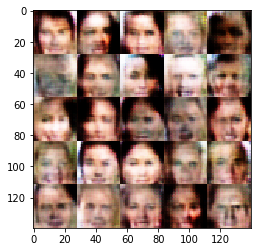

Epoch 1/1... Discriminator Loss: 0.9518... Generator Loss: 1.8422
Epoch 1/1... Discriminator Loss: 1.1293... Generator Loss: 0.8935
Epoch 1/1... Discriminator Loss: 0.9708... Generator Loss: 0.8074
Epoch 1/1... Discriminator Loss: 0.7259... Generator Loss: 0.9461
Epoch 1/1... Discriminator Loss: 0.3343... Generator Loss: 1.6216
Epoch 1/1... Discriminator Loss: 0.3864... Generator Loss: 1.4974
Epoch 1/1... Discriminator Loss: 0.9910... Generator Loss: 1.0074
Epoch 1/1... Discriminator Loss: 1.1376... Generator Loss: 0.8317
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 1.9823
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 1.7608
Epoch 1/1... Discriminator Loss: 2.5191... Generator Loss: 0.1201
Epoch 1/1... Discriminator Loss: 0.9808... Generator Loss: 0.9485
Epoch 1/1... Discriminator Loss: 1.5381... Generator Loss: 3.1162
Epoch 1/1... Discriminator Loss: 1.1110... Generator Loss: 1.0357
Epoch 1/1... Discriminator Loss: 1.0133... Generator Loss: 0.9005
Epoch 1/1.

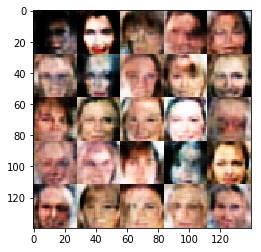

Epoch 1/1... Discriminator Loss: 0.9995... Generator Loss: 3.8086
Epoch 1/1... Discriminator Loss: 0.7802... Generator Loss: 1.5593
Epoch 1/1... Discriminator Loss: 4.1153... Generator Loss: 3.5903
Epoch 1/1... Discriminator Loss: 0.5850... Generator Loss: 1.2154
Epoch 1/1... Discriminator Loss: 0.7453... Generator Loss: 0.8613
Epoch 1/1... Discriminator Loss: 0.8211... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 0.9307... Generator Loss: 0.5748
Epoch 1/1... Discriminator Loss: 0.3159... Generator Loss: 1.8922
Epoch 1/1... Discriminator Loss: 0.7086... Generator Loss: 5.8226
Epoch 1/1... Discriminator Loss: 0.8789... Generator Loss: 1.7909
Epoch 1/1... Discriminator Loss: 0.3484... Generator Loss: 2.0210
Epoch 1/1... Discriminator Loss: 0.5106... Generator Loss: 1.2255
Epoch 1/1... Discriminator Loss: 0.9400... Generator Loss: 0.6814
Epoch 1/1... Discriminator Loss: 1.1229... Generator Loss: 3.1706
Epoch 1/1... Discriminator Loss: 0.2584... Generator Loss: 2.5241
Epoch 1/1.

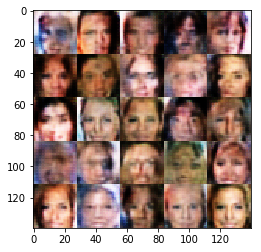

Epoch 1/1... Discriminator Loss: 0.5697... Generator Loss: 1.3829
Epoch 1/1... Discriminator Loss: 0.9125... Generator Loss: 1.0676
Epoch 1/1... Discriminator Loss: 1.1935... Generator Loss: 0.5365
Epoch 1/1... Discriminator Loss: 0.6789... Generator Loss: 1.0556
Epoch 1/1... Discriminator Loss: 0.5037... Generator Loss: 4.8520
Epoch 1/1... Discriminator Loss: 2.2847... Generator Loss: 4.3910
Epoch 1/1... Discriminator Loss: 0.6638... Generator Loss: 0.9370
Epoch 1/1... Discriminator Loss: 0.2047... Generator Loss: 2.2205
Epoch 1/1... Discriminator Loss: 0.2023... Generator Loss: 2.7827
Epoch 1/1... Discriminator Loss: 0.6554... Generator Loss: 0.9259
Epoch 1/1... Discriminator Loss: 0.4391... Generator Loss: 1.3020
Epoch 1/1... Discriminator Loss: 0.1674... Generator Loss: 2.2736
Epoch 1/1... Discriminator Loss: 1.6691... Generator Loss: 0.3170
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.3998
Epoch 1/1... Discriminator Loss: 0.7663... Generator Loss: 0.8623
Epoch 1/1.

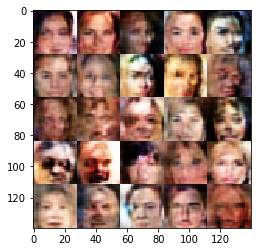

Epoch 1/1... Discriminator Loss: 0.8298... Generator Loss: 1.7070
Epoch 1/1... Discriminator Loss: 0.5344... Generator Loss: 1.2734
Epoch 1/1... Discriminator Loss: 0.7758... Generator Loss: 1.4599
Epoch 1/1... Discriminator Loss: 0.8047... Generator Loss: 0.8620
Epoch 1/1... Discriminator Loss: 0.8856... Generator Loss: 0.7530
Epoch 1/1... Discriminator Loss: 1.0932... Generator Loss: 1.7671
Epoch 1/1... Discriminator Loss: 0.2102... Generator Loss: 2.5976
Epoch 1/1... Discriminator Loss: 0.2785... Generator Loss: 3.7540
Epoch 1/1... Discriminator Loss: 2.4995... Generator Loss: 1.8591
Epoch 1/1... Discriminator Loss: 0.3866... Generator Loss: 1.8700
Epoch 1/1... Discriminator Loss: 0.1136... Generator Loss: 3.2499
Epoch 1/1... Discriminator Loss: 0.7216... Generator Loss: 3.0684
Epoch 1/1... Discriminator Loss: 0.7404... Generator Loss: 1.2652
Epoch 1/1... Discriminator Loss: 1.0148... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 0.8573... Generator Loss: 1.0742
Epoch 1/1.

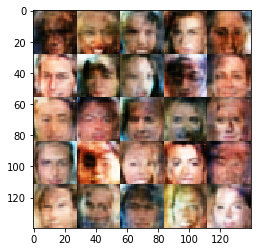

Epoch 1/1... Discriminator Loss: 0.1634... Generator Loss: 3.5276
Epoch 1/1... Discriminator Loss: 0.1794... Generator Loss: 2.3572
Epoch 1/1... Discriminator Loss: 3.6100... Generator Loss: 5.0791
Epoch 1/1... Discriminator Loss: 0.8112... Generator Loss: 1.1477
Epoch 1/1... Discriminator Loss: 0.8312... Generator Loss: 1.0789
Epoch 1/1... Discriminator Loss: 1.4766... Generator Loss: 0.4048
Epoch 1/1... Discriminator Loss: 0.8121... Generator Loss: 1.2563
Epoch 1/1... Discriminator Loss: 1.0378... Generator Loss: 1.6800
Epoch 1/1... Discriminator Loss: 0.6258... Generator Loss: 1.4197
Epoch 1/1... Discriminator Loss: 0.6970... Generator Loss: 1.2953
Epoch 1/1... Discriminator Loss: 0.9109... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 0.7343... Generator Loss: 0.9877
Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 0.4984
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 0.4508
Epoch 1/1... Discriminator Loss: 0.8118... Generator Loss: 0.8975
Epoch 1/1.

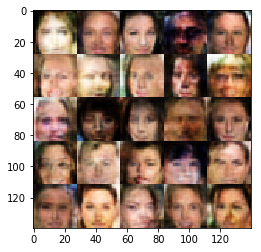

Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 0.5868
Epoch 1/1... Discriminator Loss: 0.5470... Generator Loss: 2.2201
Epoch 1/1... Discriminator Loss: 0.9576... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 0.9758... Generator Loss: 0.8413
Epoch 1/1... Discriminator Loss: 0.7063... Generator Loss: 1.1294
Epoch 1/1... Discriminator Loss: 1.5928... Generator Loss: 0.3403
Epoch 1/1... Discriminator Loss: 1.2215... Generator Loss: 0.5726
Epoch 1/1... Discriminator Loss: 0.6581... Generator Loss: 1.6976
Epoch 1/1... Discriminator Loss: 0.7892... Generator Loss: 0.9416
Epoch 1/1... Discriminator Loss: 0.2407... Generator Loss: 2.0228
Epoch 1/1... Discriminator Loss: 1.7381... Generator Loss: 0.3398
Epoch 1/1... Discriminator Loss: 1.6527... Generator Loss: 1.6945
Epoch 1/1... Discriminator Loss: 0.8393... Generator Loss: 0.9860
Epoch 1/1... Discriminator Loss: 0.7349... Generator Loss: 1.2659
Epoch 1/1... Discriminator Loss: 1.0266... Generator Loss: 0.6845
Epoch 1/1.

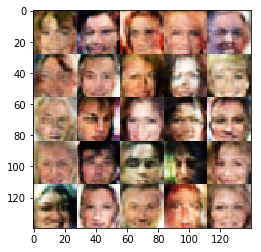

Epoch 1/1... Discriminator Loss: 0.2329... Generator Loss: 3.0021
Epoch 1/1... Discriminator Loss: 0.5261... Generator Loss: 1.2935
Epoch 1/1... Discriminator Loss: 0.5990... Generator Loss: 2.3025
Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 3.2523
Epoch 1/1... Discriminator Loss: 1.5752... Generator Loss: 0.3912
Epoch 1/1... Discriminator Loss: 0.1726... Generator Loss: 2.5032
Epoch 1/1... Discriminator Loss: 1.2970... Generator Loss: 0.4708
Epoch 1/1... Discriminator Loss: 0.8203... Generator Loss: 0.7125
Epoch 1/1... Discriminator Loss: 0.4364... Generator Loss: 3.4649
Epoch 1/1... Discriminator Loss: 0.1978... Generator Loss: 2.9213
Epoch 1/1... Discriminator Loss: 0.2514... Generator Loss: 3.0879
Epoch 1/1... Discriminator Loss: 0.2496... Generator Loss: 2.2323
Epoch 1/1... Discriminator Loss: 1.0466... Generator Loss: 3.7726
Epoch 1/1... Discriminator Loss: 1.5297... Generator Loss: 0.4610
Epoch 1/1... Discriminator Loss: 0.1461... Generator Loss: 3.2086
Epoch 1/1.

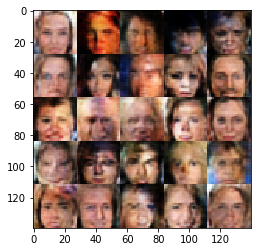

Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 1.8224
Epoch 1/1... Discriminator Loss: 0.4168... Generator Loss: 3.0700
Epoch 1/1... Discriminator Loss: 0.1918... Generator Loss: 2.4861
Epoch 1/1... Discriminator Loss: 0.7592... Generator Loss: 0.8992
Epoch 1/1... Discriminator Loss: 0.1754... Generator Loss: 2.7258
Epoch 1/1... Discriminator Loss: 0.0602... Generator Loss: 4.9187
Epoch 1/1... Discriminator Loss: 0.2237... Generator Loss: 2.1476
Epoch 1/1... Discriminator Loss: 0.0348... Generator Loss: 4.5030
Epoch 1/1... Discriminator Loss: 1.7981... Generator Loss: 2.3673
Epoch 1/1... Discriminator Loss: 0.7518... Generator Loss: 0.8701
Epoch 1/1... Discriminator Loss: 0.5774... Generator Loss: 2.2595
Epoch 1/1... Discriminator Loss: 1.0886... Generator Loss: 0.7072
Epoch 1/1... Discriminator Loss: 0.5321... Generator Loss: 2.0262
Epoch 1/1... Discriminator Loss: 0.9970... Generator Loss: 3.8004
Epoch 1/1... Discriminator Loss: 0.5496... Generator Loss: 3.2525
Epoch 1/1.

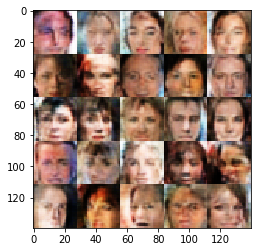

Epoch 1/1... Discriminator Loss: 0.5525... Generator Loss: 1.3156
Epoch 1/1... Discriminator Loss: 0.2000... Generator Loss: 2.2101
Epoch 1/1... Discriminator Loss: 0.6366... Generator Loss: 2.5010
Epoch 1/1... Discriminator Loss: 0.6014... Generator Loss: 1.6948
Epoch 1/1... Discriminator Loss: 0.8383... Generator Loss: 0.9275
Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.4044
Epoch 1/1... Discriminator Loss: 0.5971... Generator Loss: 1.4166
Epoch 1/1... Discriminator Loss: 0.2846... Generator Loss: 3.4777
Epoch 1/1... Discriminator Loss: 0.6791... Generator Loss: 1.3006
Epoch 1/1... Discriminator Loss: 1.1165... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 0.4626... Generator Loss: 1.3463
Epoch 1/1... Discriminator Loss: 0.1338... Generator Loss: 3.2418
Epoch 1/1... Discriminator Loss: 0.3959... Generator Loss: 1.7057
Epoch 1/1... Discriminator Loss: 0.7970... Generator Loss: 0.8784
Epoch 1/1... Discriminator Loss: 0.3092... Generator Loss: 1.8539
Epoch 1/1.

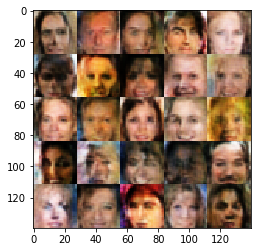

Epoch 1/1... Discriminator Loss: 0.1918... Generator Loss: 2.5642
Epoch 1/1... Discriminator Loss: 0.2430... Generator Loss: 2.8069
Epoch 1/1... Discriminator Loss: 0.0983... Generator Loss: 3.3764
Epoch 1/1... Discriminator Loss: 1.6962... Generator Loss: 0.2753
Epoch 1/1... Discriminator Loss: 0.3101... Generator Loss: 1.8547
Epoch 1/1... Discriminator Loss: 0.6665... Generator Loss: 0.9878
Epoch 1/1... Discriminator Loss: 0.3709... Generator Loss: 1.6966
Epoch 1/1... Discriminator Loss: 0.0737... Generator Loss: 4.3155
Epoch 1/1... Discriminator Loss: 0.0497... Generator Loss: 5.5368
Epoch 1/1... Discriminator Loss: 0.0590... Generator Loss: 3.6693
Epoch 1/1... Discriminator Loss: 0.6373... Generator Loss: 1.1894
Epoch 1/1... Discriminator Loss: 0.2712... Generator Loss: 1.9839
Epoch 1/1... Discriminator Loss: 0.3144... Generator Loss: 2.1512
Epoch 1/1... Discriminator Loss: 0.0541... Generator Loss: 3.9338
Epoch 1/1... Discriminator Loss: 0.0925... Generator Loss: 3.3488
Epoch 1/1.

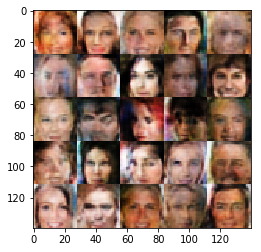

Epoch 1/1... Discriminator Loss: 0.6574... Generator Loss: 1.0890
Epoch 1/1... Discriminator Loss: 0.4113... Generator Loss: 1.9990
Epoch 1/1... Discriminator Loss: 0.5236... Generator Loss: 1.2286
Epoch 1/1... Discriminator Loss: 0.5908... Generator Loss: 1.4415
Epoch 1/1... Discriminator Loss: 0.8624... Generator Loss: 1.2330
Epoch 1/1... Discriminator Loss: 0.5929... Generator Loss: 1.0244
Epoch 1/1... Discriminator Loss: 0.2980... Generator Loss: 1.9226
Epoch 1/1... Discriminator Loss: 0.1634... Generator Loss: 4.1372
Epoch 1/1... Discriminator Loss: 0.1724... Generator Loss: 3.6711
Epoch 1/1... Discriminator Loss: 0.1394... Generator Loss: 3.6578
Epoch 1/1... Discriminator Loss: 1.0753... Generator Loss: 0.7550
Epoch 1/1... Discriminator Loss: 0.0686... Generator Loss: 3.8165
Epoch 1/1... Discriminator Loss: 0.3473... Generator Loss: 2.0019
Epoch 1/1... Discriminator Loss: 0.8575... Generator Loss: 0.7639
Epoch 1/1... Discriminator Loss: 0.4338... Generator Loss: 1.3294
Epoch 1/1.

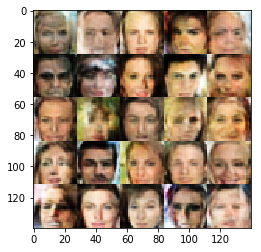

Epoch 1/1... Discriminator Loss: 0.1957... Generator Loss: 2.3001
Epoch 1/1... Discriminator Loss: 0.1828... Generator Loss: 2.5496
Epoch 1/1... Discriminator Loss: 0.3538... Generator Loss: 1.5430
Epoch 1/1... Discriminator Loss: 0.1208... Generator Loss: 4.7234
Epoch 1/1... Discriminator Loss: 0.4111... Generator Loss: 1.4790
Epoch 1/1... Discriminator Loss: 0.0709... Generator Loss: 3.5583
Epoch 1/1... Discriminator Loss: 0.0456... Generator Loss: 4.6936
Epoch 1/1... Discriminator Loss: 0.0812... Generator Loss: 3.8280
Epoch 1/1... Discriminator Loss: 0.1014... Generator Loss: 4.4648
Epoch 1/1... Discriminator Loss: 0.0902... Generator Loss: 5.6625
Epoch 1/1... Discriminator Loss: 0.1546... Generator Loss: 2.6951
Epoch 1/1... Discriminator Loss: 0.0789... Generator Loss: 6.4044
Epoch 1/1... Discriminator Loss: 0.4176... Generator Loss: 2.3245
Epoch 1/1... Discriminator Loss: 0.2977... Generator Loss: 3.0116
Epoch 1/1... Discriminator Loss: 0.5007... Generator Loss: 2.0273
Epoch 1/1.

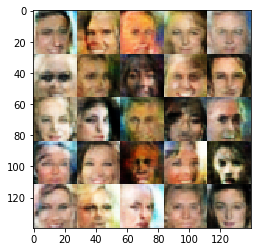

Epoch 1/1... Discriminator Loss: 0.5382... Generator Loss: 1.3021
Epoch 1/1... Discriminator Loss: 1.5797... Generator Loss: 0.2965
Epoch 1/1... Discriminator Loss: 0.2186... Generator Loss: 2.7568
Epoch 1/1... Discriminator Loss: 0.2457... Generator Loss: 2.0303
Epoch 1/1... Discriminator Loss: 0.2120... Generator Loss: 2.0846
Epoch 1/1... Discriminator Loss: 0.0732... Generator Loss: 3.9380
Epoch 1/1... Discriminator Loss: 0.3501... Generator Loss: 3.1434
Epoch 1/1... Discriminator Loss: 0.4308... Generator Loss: 1.4515
Epoch 1/1... Discriminator Loss: 0.1179... Generator Loss: 2.8438
Epoch 1/1... Discriminator Loss: 1.2253... Generator Loss: 0.5564
Epoch 1/1... Discriminator Loss: 0.3711... Generator Loss: 1.8334
Epoch 1/1... Discriminator Loss: 0.3565... Generator Loss: 1.7756
Epoch 1/1... Discriminator Loss: 0.7849... Generator Loss: 1.5204
Epoch 1/1... Discriminator Loss: 0.0847... Generator Loss: 3.7957
Epoch 1/1... Discriminator Loss: 0.0480... Generator Loss: 4.0538
Epoch 1/1.

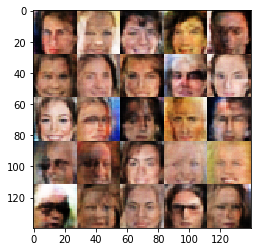

Epoch 1/1... Discriminator Loss: 0.0216... Generator Loss: 5.6771
Epoch 1/1... Discriminator Loss: 0.2965... Generator Loss: 3.2489
Epoch 1/1... Discriminator Loss: 0.0522... Generator Loss: 4.2512


IndexError: list index out of range

In [22]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.